This cell is responsible for managing imports.

In [1]:
from qiskit import Aer          # for simulator backend
from qiskit_machine_learning.algorithms import QSVC # quantum support vector classifier class
from qiskit_machine_learning.kernels.quantum_kernel import QuantumKernel # wraps feature map and backend combination to give to QSVC
import qiskit.circuit.library   # for feature maps
import numpy as np
import joblib                   # for persistence, caching, and parallelism

# for data sets and data set processing
import sklearn.datasets
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit_machine_learning.datasets.dataset_helper import features_and_labels_transform

# for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

# for encoding functions from suzuki2020.pdf paper
import data_map_functions

Start by configuring joblib's caching and parallelism and the quantum backend. Parallelism and caching help save time and recover from power outages and shouldn't affect the final results. If the backend configuration is changed, the cache folder should be deleted so that the experiments run with the new backend and don't simply recall results from a previous backend.

In [2]:
# configure caching
cache_directory = "./joblib_cache"
memory = joblib.Memory(location=cache_directory, compress=False, mmap_mode=None)
# configure parallelism
worker_count = 6                # this should be set to 1 for debugging (makes stack traces nicer)
parallel = joblib.Parallel(n_jobs=worker_count, backend="loky", batch_size=1, mmap_mode=None)
#configure backend
backend = Aer.get_backend("aer_simulator_statevector") # should configure this to mimic IBMQ backend
#backend.set_options(device='GPU')                      # enable GPU acceleration (comment this line to disable)

The functions in this cell are responsible for loading, preparing, and splitting data sets for input to the QSVM classifier.

In [3]:
def load_raw_datasets(seed=22):
    """This loads the sci-kit learn data set objects without performing any further
    processing on them. It also returns a readable name for each one."""
    return [sklearn.datasets.make_blobs(n_samples=150, n_features=4, random_state=seed), # create artificial blobs data set
            sklearn.datasets.load_breast_cancer(),
            sklearn.datasets.load_digits(),
            sklearn.datasets.load_iris(),
            sklearn.datasets.load_wine()]

def extract_binary_classes(feature_array, label_array):
    """Takes a numpy array of feature vectors and a numpy array of labels
    and returns transformed numpy arrays with the number of classes reduced
    to 2. Picks two random classes."""
    # get 2 random classes based on the seed, and output what they are
    all_classes = list(set(label_array))
    classes = np.random.choice(all_classes, size=2, replace=False) # must have replace=False to guarantee different classes
    print(f"Choosing classes {classes}.")
    class_map = {classes[0]:0, classes[1]:1} # convert labels to 0 and 1 (needed for training step)
    # construct a feature and label description with information from only the first 2 classes
    features = []
    labels = []
    for (feature, label) in zip(feature_array, label_array):
        if label in classes:
            features.append(feature)
            labels.append(label)
    return (np.array(features), np.array(labels))

def process_dataset(feature_vectors, labels, qubit_count, binary_classification=True):
    """Performs scaling and dimensionality reduction on all feature vectors of a data set,
    then returns the processed vectors. It will also extract 2 classes from the data set
    if binary_classification is True, rather than leaving the data set as a multi-class data set.
    Some of this code is modified from the qiskit_machine_learning data set loading
    source code (check qiskit_machine_learning.datasets.digits source code for exact location
    of what was modified from)."""
    # maybe extract classes for binary classification
    if binary_classification:
        feature_vectors, labels = extract_binary_classes(feature_vectors, labels)

    # Now we standardize for gaussian around 0 with unit variance
    scaler = StandardScaler()
    scaler.fit(feature_vectors)
    feature_vectors = scaler.transform(feature_vectors)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=qubit_count)
    pca.fit(feature_vectors)
    feature_vectors = pca.transform(feature_vectors)

    # Scale to the range (-1,+1)
    minmax_scaler = MinMaxScaler((-1, 1)).fit(feature_vectors)
    feature_vectors = minmax_scaler.transform(feature_vectors)

    # perform some other transformation on the feature and label vectors
    # as was done in the qiskit_machine_learning source code
    dataset_dict = {label:np.array([feature_vector for feature_vector, feature_vector_label in zip(feature_vectors, labels)
                                    if feature_vector_label == label])
                    for label in list(set(labels))}
    feature_vectors, labels = features_and_labels_transform(dataset_dict, labels, one_hot=False)

    return feature_vectors, labels

def cross_fold_sets(data, labels, k=5, seed=22):
    "Given a data set's feature and label arrays, yield training and testing feature and label arrays for k-fold validation. If the same seed is used then the same subsets should be returned across different calls."
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    # for each of the k train-test splits:
    for train_indices, test_indices in kf.split(data, labels):
        # helper function
        extract_elements = lambda array, indices: np.array([array[i] for i in indices])
        # get training and testing feature vectors
        train_features = extract_elements(data, train_indices)
        test_features = extract_elements(data, test_indices)
        # get training and testing labels
        train_labels = extract_elements(labels, train_indices)
        test_labels = extract_elements(labels, test_indices)
        # return current split values
        yield (train_features, train_labels, test_features, test_labels)

This cell defines a function that can be given some parameters determining a classifier, like the feature map to use, the data to train on, and the backend to run the training on.

In [4]:
def make_classifier(feature_map_instance, training_features, training_labels):
    """Given a feature map instance, training features and labels,
    creates, trains, and returns a QSVM classifier."""
    # Create a quantum kernel from the feature map and
    # backend to give to the QSVC class.
    quantum_kernel = QuantumKernel(feature_map=feature_map_instance, quantum_instance=backend) # the batch_size argument is left as default since it just controls the number of circuits computed at once (irrelevant to results)
    # Create a QSVC instance
    qsvc = QSVC(quantum_kernel=quantum_kernel) # TODO: also set sklearn parameters here (look up the relevant ones)
    # Perform training
    qsvc.fit(training_features, training_labels)
    # return classifier instance
    return qsvc

This cell configures global variables relevant to creating classifier configurations, including performing the loading of datasets into memory.

In [5]:
# set a fixed seed so that caching works
seed = 22
np.random.seed(seed)

# pick number of qubits / number of features
qubit_count = 4

# load datasets
datasets = load_raw_datasets(seed=seed)
dataset_names = ["blobs", "cancer", "digits", "iris", "wine"] # these should correspond to datasets returned by load_raw_datasets()

# list encoding functions
data_encoding_functions = [data_map_functions.data_map_one,
                           data_map_functions.data_map_two,
                           data_map_functions.data_map_three,
                           data_map_functions.data_map_four,
                           data_map_functions.data_map_five]
data_encoding_function_names = ["(8)", "(9)", "(10)", "(11)", "(12)"] # these names are the numberings used in the paper

# feature map classes
feature_map_class_list = [qiskit.circuit.library.PauliFeatureMap,
                          qiskit.circuit.library.ZFeatureMap,
                          qiskit.circuit.library.ZZFeatureMap]
feature_map_names = ["Pauli", "Z", "ZZ"]

# A value of 5 gives a 20:80 test:train split, and 5 total validation splits
cross_validation_splits = 5 

# this setting applies only to the ZZ feature map
number_of_investigated_repetition_values = 4 # for trying depth = 2, 3, 4, and 5

In [6]:
def decision_boundary_distances(model, datapoints):
    """Takes a QSVC model and some data points and returns a list
    of distances of each data point from the decision boundary of
    the model. This function works for two class models and for
    multiclass models created with the decision_function_shape="ovo"
    option."""
    def norm(vector):
        """Returns the norm of an n-dimensional argument vector."""
        return np.sqrt(np.sum(np.square(vector)))
    # get decision function output and weight vector
    proportional_distances = model.decision_function(datapoints)
#    weight_vector = model.coef_
#    correction_factor = 1 / norm(weight_vector)
#    true_distances = correction_factor * decision_function_values
    # return exact distances from decision function boundary for each data point
    return proportional_distances #true_distances

# TODO: add checks to only calculate distances of data points from the decision boundary
# if the classifier being trained is for the cases that will be graphed (ZZ, 2 repetitions,
# data map function (8) or (10)). This can just be done to save time.
def generalization_metrics(model, train_features, train_labels, test_features, test_labels):
    """Calculates test and train accuracies as well as distances of testing set points from the
    model's decision boundary. Also returns the model."""
    distances = decision_boundary_distances(model, test_features)
    train_accuracy = model.score(train_features, train_labels)
    test_accuracy = model.score(test_features, test_labels)
    return train_accuracy, test_accuracy, distances, model

This cell defines process_combination, a function that does the job of creating, training, and evaluating a single classifier configuration. It is in its own cell so that all the code using caching can be confined to one part of the program.

In [7]:
# Define the uncached version of the function
def process_combination_uncached(feature_map_class, data_split_tuple, data_map_function, repetitions, qubit_count):
    """Takes a feature map class number, dataset loading function, and a backend, and
    returns the generalisation metrics of the combination of arguments."""
    # Create the feature map instance.
    feature_map_instance = feature_map_class(feature_dimension=qubit_count, reps=repetitions, data_map_func=data_map_function)
    # unpack the data split to get the features and labels
    train_features, train_labels, test_features, test_labels = data_split_tuple

    # create the classifier
    qsvc = make_classifier(feature_map_instance, train_features, train_labels)

    # return the generalisation metrics and the trained model for later inspection convenience
    return generalization_metrics(qsvc, train_features, train_labels, test_features, test_labels)

# Define the main version of the function (process_combination), optionally with cache use.
# Note that due to a joblib bug the code must be exported from the notebook to a .py file for caching to
# work if multiple threads are used. It might be fixed in a newer joblib version? (see this link for the bug:
# https://bleepcoder.com/joblib/608955182/using-memory-and-parallel-with-cached-function-defined)
use_checkpointing = True
process_combination = memory.cache(process_combination_uncached) if use_checkpointing else process_combination_uncached

This cell defines generate\_all\_combinations, which isolates a complex nested loop for creating all tested experiment configurations.

In [8]:
def generate_all_combinations():
    """Returns a list of pairs, with the first element of each pair being an argument list"""
    print("Generating classifier configurations...")
    combinations = []
    for dataset, dataset_name in zip(datasets, dataset_names):
        # output dataset name
        print(f"{dataset_name} dataset:")
        # Perform dimensionality reduction and scaling on the features,
        # and transform the labels as done in the qiskit_machine_learning
        # data set loading source code. Also prepares the data for
        # binary rather than multi-class classification if enabled.
        if dataset_name == "blobs": # special case is for the blobs data set, which is not loaded as a dataset object but generated as a pair of features and labels
            blob_features, blob_labels = dataset # unpack pair
            features, labels = process_dataset(blob_features, blob_labels, qubit_count=qubit_count)
        else:
            features, labels = process_dataset(dataset.data, dataset.target, qubit_count=qubit_count)
        print(f"{len(features)} feature vectors.")
        # For each k-fold split of the data into training and testing sets
        for (split_number, split_tuple) in enumerate(cross_fold_sets(features, labels, k=cross_validation_splits)):
            # For each feature map
            for feature_map_class, feature_map_name in zip(feature_map_class_list, feature_map_names):
                if feature_map_name == "Z":
                    # for Z map, just do 2 repetitions with default encoding function (data_map_one, or data_encoding_functions[0])
                    process_combination_args = (feature_map_class, split_tuple, data_encoding_functions[0], 2, qubit_count) # to be passed to process_combination
                    identifying_key = (dataset_name, split_number, feature_map_name, data_encoding_function_names[0], 2) # to identify the combination in the results dictionary
                    combinations.append((process_combination_args, identifying_key))
                elif feature_map_name == "ZZ":
                    # for ZZ map, try all encoding functions and repetitions
                    for (data_encoding_function, data_encoding_function_name) in zip(data_encoding_functions, data_encoding_function_names):
                        for reps in range(2, 2+number_of_investigated_repetition_values):
                            process_combination_args = (feature_map_class, split_tuple, data_encoding_function, reps, qubit_count) # to be passed to process_combination
                            identifying_key = (dataset_name, split_number, feature_map_name, data_encoding_function_name, reps) # to identify the combination in the results dictionary
                            combinations.append((process_combination_args, identifying_key))
                elif feature_map_name == "Pauli":
                    # for Pauli map, try all encoding functions and 2 repetitions
                    for (data_encoding_function, data_encoding_function_name) in zip(data_encoding_functions, data_encoding_function_names):
                        process_combination_args = (feature_map_class, split_tuple, data_encoding_function, 2, qubit_count) # to be passed to process_combination
                        identifying_key = (dataset_name, split_number, feature_map_name, data_encoding_function_name, 2) # to identify the combination in the results dictionary
                        combinations.append((process_combination_args, identifying_key))
    return combinations

This cell defines process\_all\_combinations  which returns a dictionary pairing classifier configurations to experiment results. It makes use of the generate\_all\_combinations function above, as well as process_combination. It has its own cell so that the code making use of threads can be isolated from the rest of the program.

In [9]:
def results_from_combination(combination):
    """Helper to run process_combination with arguments from the first element of a pair
    and return a (key, value) tuple for storing the result in a dictionary."""
    # unpack the combination
    (pc_args, identifying_key) = combination
    # run experiment for this configuration
    results = process_combination(*pc_args)
    # return results as a key-value pair
    return (identifying_key, results)

def process_all_combinations():
    """Runs all experiments."""
    # output number of classifiers that need to be trained (to guess running time)
    combination_count = (len(datasets) * cross_validation_splits * len(data_encoding_functions) * number_of_investigated_repetition_values # number of ZZ combinations
                         + len(datasets) * cross_validation_splits * len(data_encoding_functions)  # number of Pauli combinations
                         + len(datasets) * cross_validation_splits)  # number of Z combinations
    print(f"Running with {len(datasets)} datasets, {len(feature_map_class_list)} feature maps, {number_of_investigated_repetition_values} different encoding repetitions for the ZZ feature map, {len(data_encoding_functions)} data map functions for the ZZ and Pauli feature maps, and {cross_validation_splits}-fold cross validation, requiring the training of {combination_count} classifiers in total.")

    # create a list of each possible combination / classifier
    # configuration so that they can be processed in parallel
    combinations = generate_all_combinations()

    # process each combination in parallel
    print("Creating, training, and testing classifiers...")
    key_value_result_pairs = parallel(joblib.delayed(results_from_combination)(combination) for combination in combinations)
    # create the results dictionary
    results_table = {}
    for (k, v) in key_value_result_pairs:
        results_table[k] = v
    return results_table

This cell defines a function that runs process\_all\_combinations, prints out the results, and saves the trained models.

In [10]:
models = []
def main():
    results = process_all_combinations()
    for combination in results:
        train, test, distances, model = results[combination]
        models.append((combination, model)) # store the model and the configuration used to create it
        print(f"Combination {combination} has train/test accuracies {train}/{test}.")
    joblib.dump(models, "trained_models.cache") # save all models to a file so they can be inspected later if desired
    return results

This cell can be evaluated to actually perform the experiments. It can take a few hours to run so loading pre-computed results is preferred if applicable.

In [ ]:
#results = main()                # uncomment this when you want to run it (to prevent running accidentally)

The next 3 cells should be run selectively to save and load pre-computed results. This caching is secondary to the memoization caching on individual functions, it just saves and loads the results variable only.

In [12]:
def save_results():
    """Saves results to a file if there are any, overwriting previous results."""
    if results != None:
        joblib.dump(results, "results.cache")
def load_results():
    """Loads results from a file."""
    global results
    results = joblib.load("results.cache")

In [ ]:
#save_results() # uncomment this when you want to run it (to prevent accidentally running it)

In [13]:
#load_results() # uncomment this when you want to run it (to prevent accidentally running it)

These 2 cells read the results variable and combine cross-validation runs to get statistics.

In [14]:
def combine_cross_validations():
    def extract_cross_validations(combination):
        """Returns a list of training and a list of testing accuracies for the given
        combination, using the values in the results from the different cross-validation
        runs."""
        dataset_name, feature_map_name, data_encoding_function_name, repetitions = combination
        train_list = []
        test_list = []
        distances_list = []
        for key in results:
            (d_name, run, f_name, ef_name, rep) = key
            if d_name == dataset_name and f_name == feature_map_name and ef_name == data_encoding_function_name and rep == repetitions:
                train_accuracy, test_accuracy, distances, model = results[key]
                train_list.append(train_accuracy)
                test_list.append(test_accuracy)
                distances_list.append(distances)
        return train_list, test_list, distances_list
    # extract combinations to get statistics about from the results variable
    combinations = set()
    for key in results:
        (d_name, run, f_name, ef_name, rep) = key
        combinations.add((d_name, f_name, ef_name, rep))
    stats = {}
    for c in combinations:
        train_accuracies, test_accuracies, distances = extract_cross_validations(c)
        stats[c] = ((np.mean(train_accuracies), np.std(train_accuracies), np.var(train_accuracies)),
                    (np.mean(test_accuracies), np.std(test_accuracies), np.var(test_accuracies)),
                    distances) # distances here is a list of the distances of testing data points from the classifier decision boundary for each cross validation of combination c
    return stats

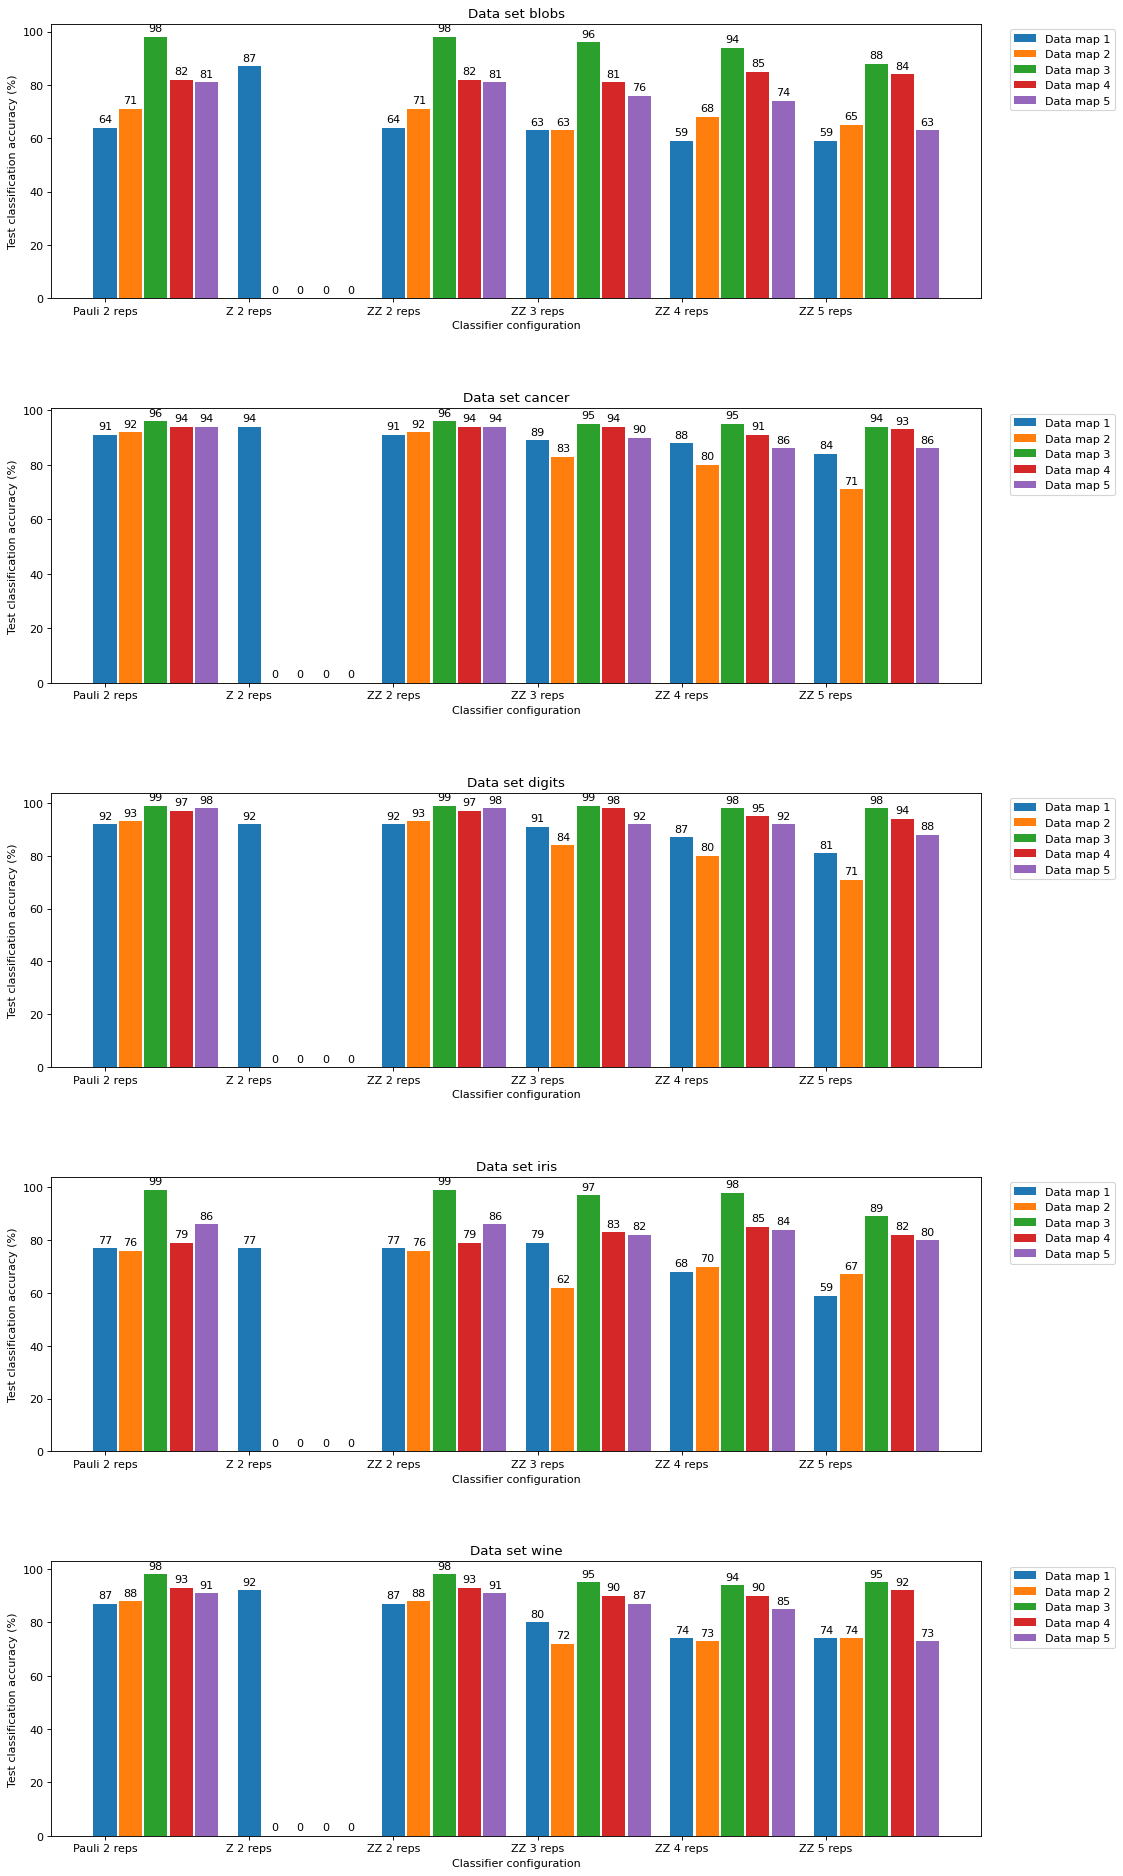

In [15]:
# combine cross validations
combined_results = combine_cross_validations()

# create a separate figure and pair of axes for each dataset
axes_count = len(datasets)
fig, axs = plt.subplots(axes_count, figsize=(15, 30), dpi=80)

# set vertical spacing between graphs
plt.subplots_adjust(hspace=0.4)

group_labels = ["Pauli 2 reps", "Z 2 reps", "ZZ 2 reps", "ZZ 3 reps", "ZZ 4 reps", "ZZ 5 reps"]
x = np.arange(len(group_labels))      # group label locations
width = 0.16                     # width of each bar group

def to_percent(fraction):
    """Converts an accuracy fraction to a percentage, floored to the nearest percent."""
    percent = fraction * 100
    floored = percent // 1
    return floored

def extract_ys(dataset_name, encoding_function_name):
    def mean_test_accuracy(feature_map_name, repetitions):
        # special case: asked for encoding function other than (8) for Z feature map.
        # They weren't simulated but should return the same value as for (8), although this
        # just returns 0 to not claim any results not actually run.
        if feature_map_name == "Z" and encoding_function_name != "(8)":
            return 0
        combination_stats = combined_results[(dataset_name, feature_map_name, encoding_function_name, repetitions)]
        return to_percent(combination_stats[1][0]) # this indexing gives mean test classification accuracy statistic.
    return [mean_test_accuracy("Pauli", 2),
            mean_test_accuracy("Z", 2),
            mean_test_accuracy("ZZ", 2),
            mean_test_accuracy("ZZ", 3),
            mean_test_accuracy("ZZ", 4),
            mean_test_accuracy("ZZ", 5)]

# for each pair of axes and the corresponding dataset name
for dataset_name, ax in zip(dataset_names, axs):
    # get test set generalizations
    y1s = extract_ys(dataset_name, "(8)")
    y2s = extract_ys(dataset_name, "(9)")
    y3s = extract_ys(dataset_name, "(10)")
    y4s = extract_ys(dataset_name, "(11)")
    y5s = extract_ys(dataset_name, "(12)")
    # plot rects for each encoding function
    space=0.1*width
    rects1 = ax.bar(x, y1s, width, label="Data map 1")
    rects2 = ax.bar(x + 1*(width+space), y2s, width, label="Data map 2")
    rects3 = ax.bar(x + 2*(width+space), y3s, width, label="Data map 3")
    rects4 = ax.bar(x + 3*(width+space), y4s, width, label="Data map 4")
    rects5 = ax.bar(x + 4*(width+space), y5s, width, label="Data map 5")
    # add labeling things (title, axes, legend)
    ax.set_title(f"Data set {dataset_name}")
    ax.set_ylabel("Test classification accuracy (%)")
    ax.set_xlabel("Classifier configuration")
    ax.set_xticks(x)
    ax.set_xticklabels(group_labels)
    ax.legend(bbox_to_anchor=(1.15, 1))
    # add more x-axis labels (for each group)
    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    ax.bar_label(rects4, padding=3)
    ax.bar_label(rects5, padding=3)

#fig.tight_layout()


This cell outputs distributions for distances of test-set data points from the classifier margins for the ZZ feature map with 2 repetitions and data map functions 1 and 3 (the worst and best performing data map functions) for each data set.

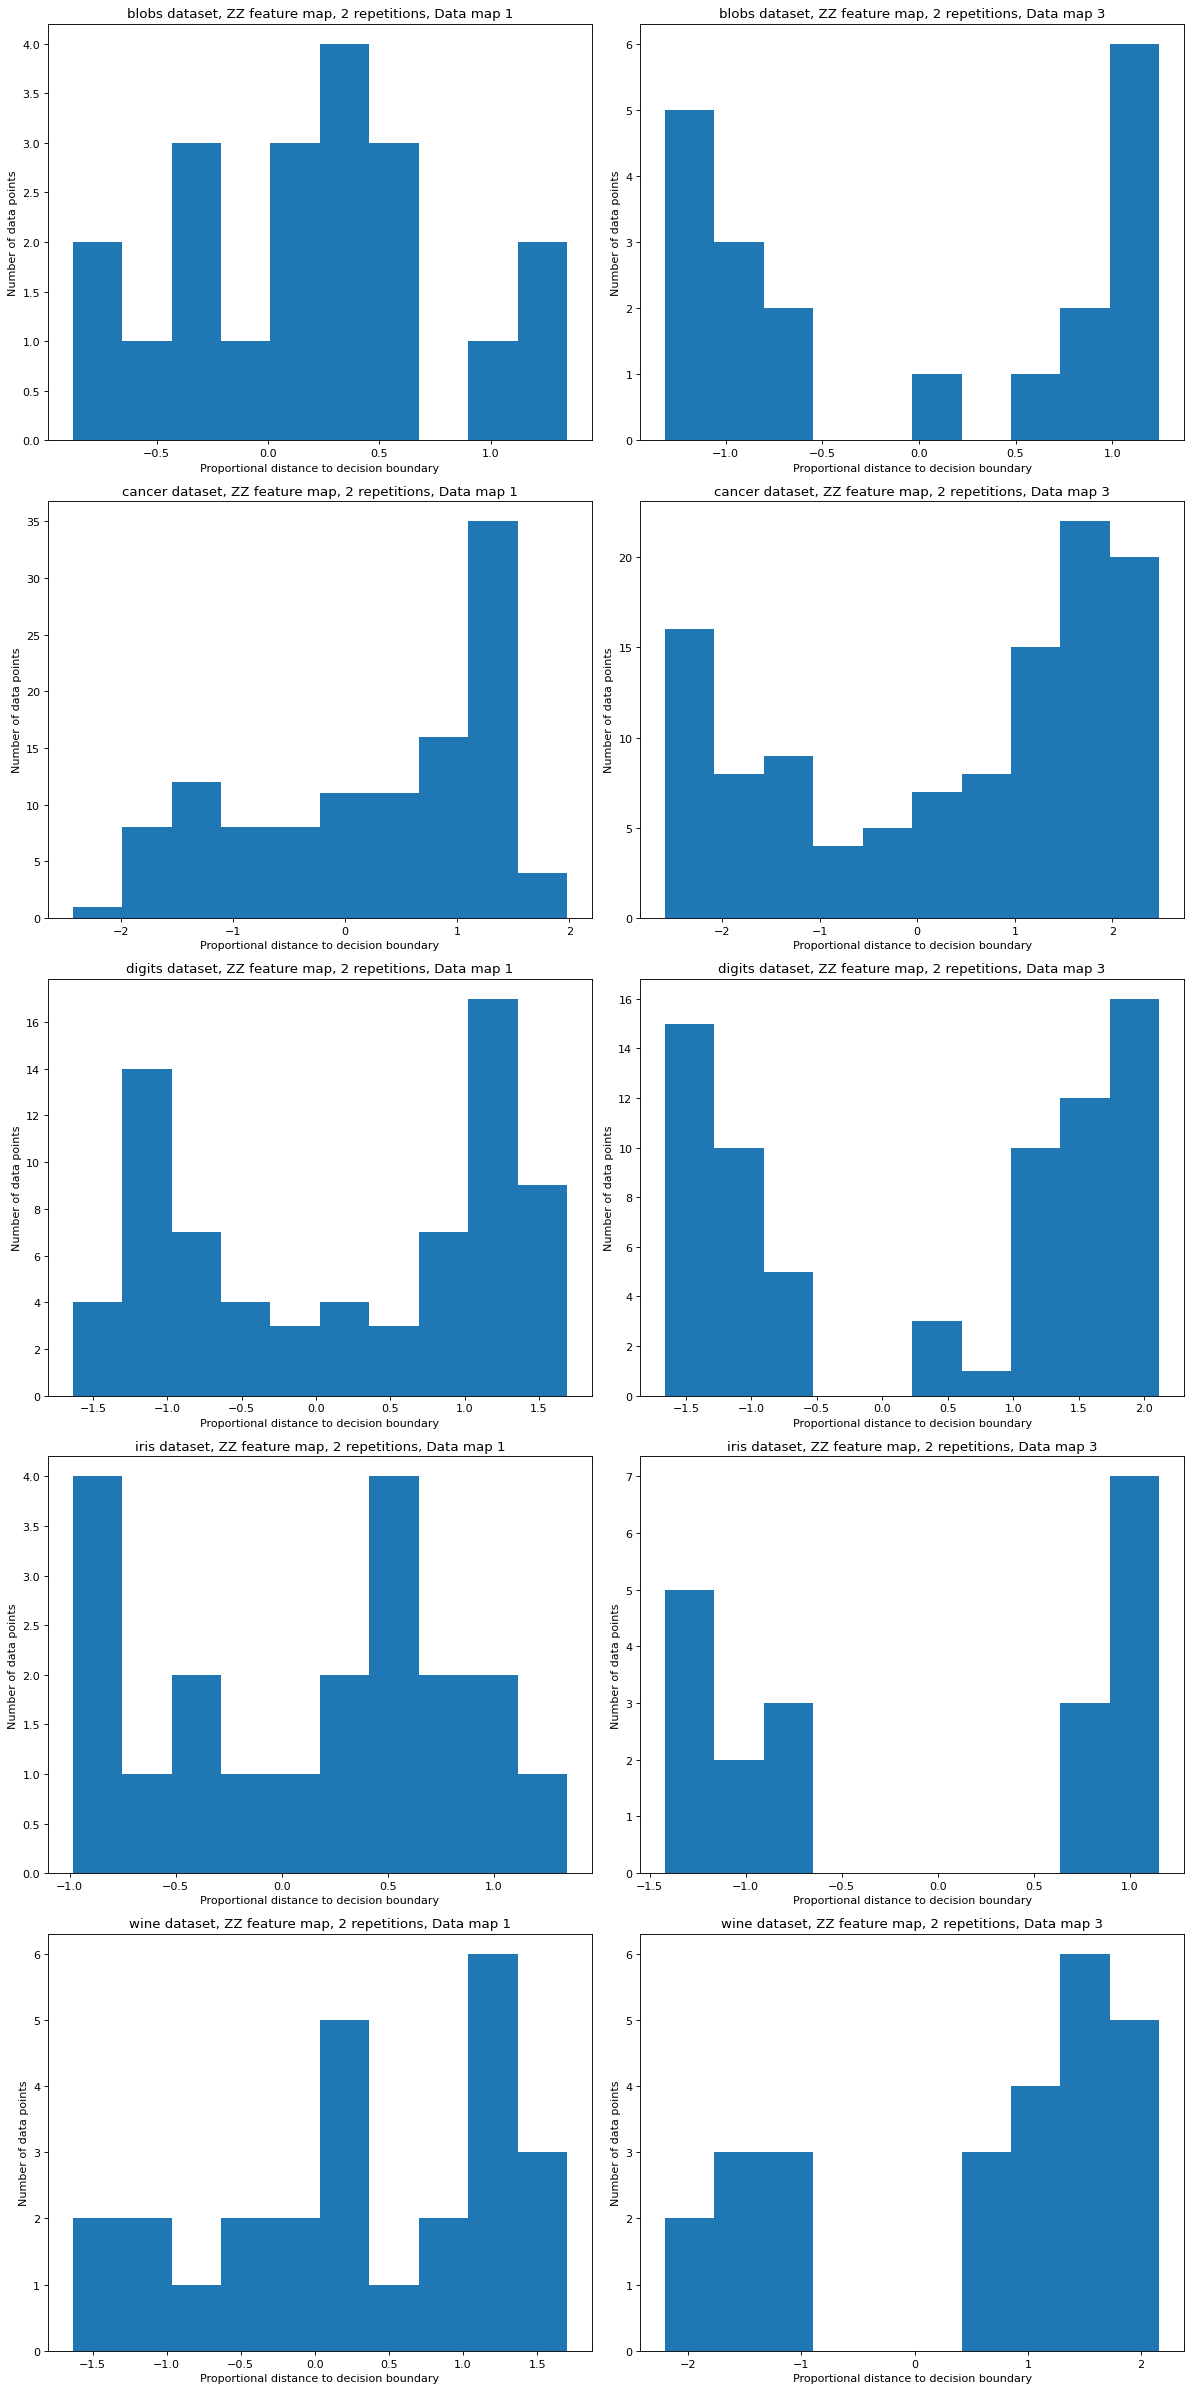

In [23]:
# combine cross validation results
plottable_margin_results = combine_cross_validations()

# create axes
fig, axs = plt.subplots(5, 2, figsize=(15, 30), dpi=80) # 5 datasets, 2 graphs each (one for each data map function)

def extract_distances_from_margin(dataset_name, encoding_function_name):
    return plottable_margin_results[(dataset_name, "ZZ", encoding_function_name, 2)][2][0] # [2] for retrieving margin distances of all cross-validations, [0] for using distances from first cross-validation

for index, dataset_name in enumerate(dataset_names):
    # get 2 horizontally adjacent axes for this dataset
    ax1 = axs[index, 0]
    ax2 = axs[index, 1]
    # get margin distances lists
    dist1 = extract_distances_from_margin(dataset_name, "(8)") # (8) is name of data map 1, the worst performing data map
    dist2 = extract_distances_from_margin(dataset_name, "(10)") # (10) is name of data map 3, the best performing data map
    # draw histograms
    ax1.hist(dist1)
    ax2.hist(dist2)
    # add labels
    ax1.set_xlabel("Proportional distance to decision boundary")
    ax1.set_ylabel("Number of data points")
    ax2.set_xlabel("Proportional distance to decision boundary")
    ax2.set_ylabel("Number of data points")
    ax1.set_title(dataset_name + " dataset, ZZ feature map, 2 repetitions, Data map 1")
    ax2.set_title(dataset_name + " dataset, ZZ feature map, 2 repetitions, Data map 3")

fig.tight_layout()